In [1]:
%matplotlib inline

import os
import numpy as np
from analysis.models.vr import RatCAVESession
from analysis.plots.placecells.F02_AB_cells import all_AB_cells, shift_plot, single_unit_plot
from analysis.plots.trajectory import arena_vs_animal_positions

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Overview

In [76]:
# 00908
sessions = [
    "2019-07-13_14-30-15",  # 3-6, 3-14 arena locked, 3-7, 3-11 VR locked, 2-4 field dissapears, 3-13 remapping
    "2019-07-14_15-42-00",  # 3-6, 3-9, 3-10, 3-11, 3-12 arena locked, 3-8 VR-locked?, 3-5 field dissapears, 3-7 remapping 
    "2019-07-15_16-10-53",  # 3-3, 3-4, 3-8 arena-locked, 3-6 VR-locked?
    "2019-07-15_22-28-43",  # 3-3, 3-5, arena-locked, 3-2, 3-4, 3-6 VR-locked
    "2019-07-23_22-28-17"   # 3-6 arena-locked, 3-2, 3-3, 3-4, 3-5, 3-7, 3-9 VR-locked
]

# 002784
sessions = [
    "2019-08-01_15-37-59"   # poor data (no running)
]

# 00910
sessions = [
    "2019-07-24_10-59-13",  # many cells, complete remapping?
    "2019-07-25_20-54-31",  # 5-2, 5-3, 5-6, still poor
    "2019-08-07_09-30-56"   # some cells, little but effect
]


source = '/home/andrey/storage2/andrey/data/processed'
animal = '00908'
session_id = '2019-07-14_15-42-00'

sessionpath = os.path.join(source, animal, session_id)

session = RatCAVESession(sessionpath, alpha=4.3)
running_idxs = session.get_running_indexes()[0]

#session.trajectory = session.trajectory[500:]  # remove first 5 seconds to exclude bad positions

if not os.path.exists(os.path.join(sessionpath, 'analysis')):
    os.makedirs(os.path.join(sessionpath, 'analysis'))
    
if not os.path.exists(os.path.join(sessionpath, 'units')):
    os.makedirs(os.path.join(sessionpath, 'units'))

In [77]:
session.tetrode_unit_map

{1: [],
 2: [],
 3: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 4: [],
 5: [],
 6: [],
 7: [],
 8: []}

# Preparing data

In [78]:
t_start = session.trajectory[0][0]
t_shift = t_start + 300


# arena was shifted! compensate
#idx_shift = np.abs(session.trajectory[:, 0] - t_shift).argmin()
#session.trajectory[:idx_shift, 2] -= 0.154  # actual arena shift


# cut the bad data outside arena
x_lim = [-0.55, 0.20]
y_lim = [-0.75, 0.90]

traj = session.trajectory
session.trajectory = traj[(traj[:, 1] > x_lim[0]) & (traj[:, 1] < x_lim[1]) & (traj[:, 2] > y_lim[0]) & (traj[:, 2] < y_lim[1])]

# Arena positions before and after the VR shift
traj = session.arena_trajectory
ar_traj_0 = np.array(traj[(traj[:, 0] < t_shift)])
ar_traj_1 = np.array(traj[(traj[:, 0] > t_shift)])

# Animal positions before and after the VR shift
traj = session.trajectory
an_traj_0 = np.array(traj[(traj[:, 0] < t_shift)])
an_traj_1 = np.array(traj[(traj[:, 0] > t_shift)])

an_traj_0_idxs = np.where((traj[:, 0] < t_shift))[0]
an_traj_1_idxs = np.where((traj[:, 0] > t_shift))[0]

# l0 = len(an_traj_0)
# l1 = len(an_traj_1)

# an_traj_0_idxs = np.linspace(0, l0, l0 + 1, dtype=np.int32)
# an_traj_1_idxs = np.linspace(l0 + 1, l0 + l1 - 1, l1 - 1, dtype=np.int32)

# Arena and animal Z positions

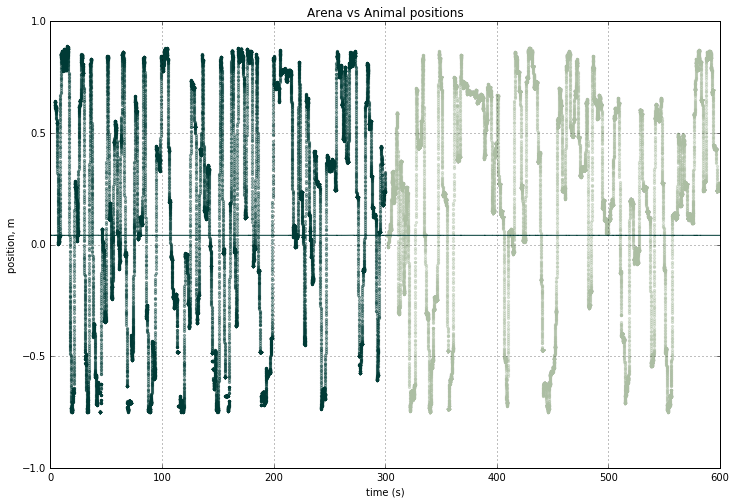

In [79]:
fig = arena_vs_animal_positions(session.arena_trajectory, an_traj_0, an_traj_1)

# All cells firing maps

Processing unit group 3..

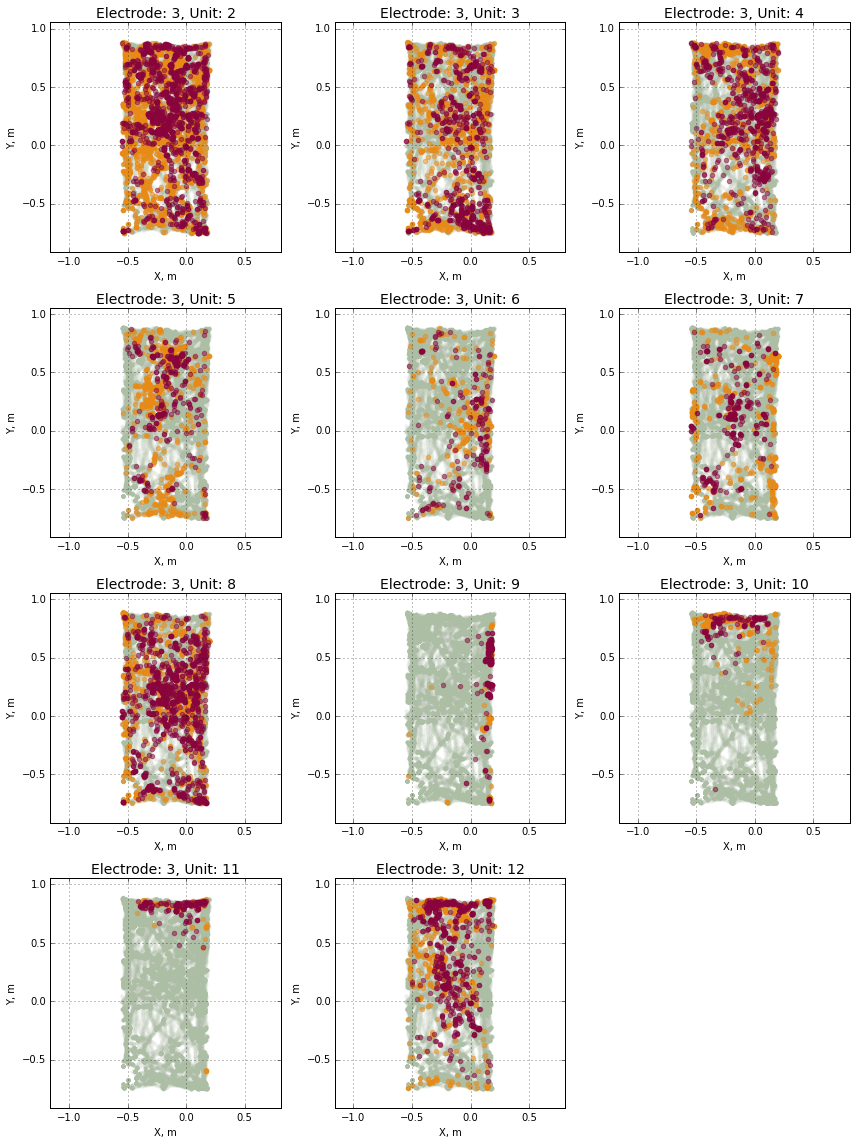

In [80]:
fig = all_AB_cells(session, an_traj_0_idxs, an_traj_1_idxs)

filename = "all_units.png"
fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))

# Shift comparison

In [81]:
def get_data_for_fields(session, ttd, unit, an_traj_0, an_traj_1, an_traj_0_idxs, an_traj_1_idxs, sampling_rate=50):
    # positions when unit fires for A + 0 and A + 30
    unit_fire_0 = session.get_positions_for_unit(ttd, unit, an_traj_0_idxs, refresh=True)
    unit_fire_1 = session.get_positions_for_unit(ttd, unit, an_traj_1_idxs, refresh=True)

    # all positions for A + 0
    pos_at_f0 = [an_traj_0[0]]
    for pos in an_traj_0:
        if pos[0] - pos_at_f0[-1][0] > (1 / float(sampling_rate)):
            pos_at_f0.append(pos)

    pos_at_f0 = np.array(pos_at_f0)

    # all positions for A + 30
    pos_at_f1 = [an_traj_1[0]]
    for pos in an_traj_1:
        if pos[0] - pos_at_f1[-1][0] > (1 / float(sampling_rate)):
            pos_at_f1.append(pos)

    pos_at_f1 = np.array(pos_at_f1)
    
    return unit_fire_0, unit_fire_1, pos_at_f0, pos_at_f1

In [82]:
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from analysis.plots.placecells.utils import get_figure_size, get_extent
from analysis.models.analytics import place_field_2D

    
def shift_place_plot(session, ttd_map, an_traj_0, an_traj_1, an_traj_0_idxs, an_traj_1_idxs):
    units_total = len([unit for ttd in ttd_map.values() for unit in ttd])
    fig = figure(figsize=(4 * 4, 4 * units_total))

    counter = 0
    sampling_rate = 50
    extent = get_extent(session.trajectory[:, 1:3])
    limits = get_figure_size(session.trajectory[:, 1:3], border=0.3)
    img = plt.imread(os.path.join(session.path, "arena.png"))    
    
    # H lines
    l1_y = session.trajectory[:, 2].max()
    l2_y = (session.trajectory[:, 2].max() - session.trajectory[:, 2].max()) / 2

    def get_y_of_field_max(firing_map):
        traj = session.trajectory
        coords = np.where(firing_map == firing_map.max())
        xi, yi = coords[0][0], coords[1][0]
        return traj[:, 2].min() + (yi / len(firing_map[0])) * (traj[:, 2].max() - traj[:, 2].min())

    for ttd, units in ttd_map.items():
        print('\rProcessing unit group %s..' % str(ttd), end="")
        
        for unit in units:
            unit_fire_0, unit_fire_1, pos_at_f0, pos_at_f1 = get_data_for_fields(session, ttd, unit, an_traj_0, an_traj_1, an_traj_0_idxs, an_traj_1_idxs)

            # unit firing in position A + 0
            ax = fig.add_subplot(units_total, 4, 4 * counter + 1)
            ax.grid(True)
            ax.set_xlabel('X, m')
            ax.set_ylabel('%s / %s, Y, m' % (ttd, unit))
            ax.set_xlim(limits[0], limits[1])
            ax.set_ylim(limits[2], limits[3])
            ax.scatter(an_traj_0[:, 1], an_traj_0[:, 2], s=10, alpha=0.05, color='#acbea3')
            ax.scatter(unit_fire_0[:, 1], unit_fire_0[:, 2], alpha=0.2, color='#e98a15')
            ax.imshow(img, extent=[-0.95, -0.65, -0.85, 1.2])
            ax.axhline(l1_y, 0.2, 0.8, linewidth=3, color='#acbea3')
            ax.axhline(l2_y, 0.2, 0.8, linewidth=3, color='#acbea3')

            # unit firing in position A + 30
            ax = fig.add_subplot(units_total, 4, 4 * counter + 2)
            ax.grid(True)
            ax.set_xlabel('X, m')
            ax.set_xlim(limits[0], limits[1])
            ax.set_ylim(limits[2], limits[3])
            ax.scatter(an_traj_1[:, 1], an_traj_1[:, 2], s=10, alpha=0.05, color='#acbea3')
            ax.scatter(unit_fire_1[:, 1], unit_fire_1[:, 2], alpha=0.2, color='#89043d')
            ax.imshow(img, extent=[-0.95, -0.65, -1.15, 0.9])
            ax.axhline(l1_y - 0.3, 0.2, 0.8, linewidth=3, color='#acbea3')
            ax.axhline(l2_y - 0.3, 0.2, 0.8, linewidth=3, color='#acbea3')

            # field Arena + 0
            omap, smap, fmap, s_firing_map_0 = place_field_2D(pos_at_f0[:, 1:3], unit_fire_0[:, 1:3], sampling_rate, 0.03)
            ax = fig.add_subplot(units_total, 4, 4 * counter + 3)
            ax.grid(True)
            ax.set_xlabel('X, m')
            ax.set_xlim(limits[0], limits[1])
            ax.set_ylim(limits[2], limits[3])
            ax.imshow(s_firing_map_0.T, cmap='jet', origin='lower', extent=extent)
            ax.axhline(get_y_of_field_max(s_firing_map_0), 0.2, 0.8, linewidth=3, color='#89043d')
            

            # field Arena + 30
            omap, smap, fmap, s_firing_map_1 = place_field_2D(pos_at_f1[:, 1:3], unit_fire_1[:, 1:3], sampling_rate, 0.03)
            ax = fig.add_subplot(units_total, 4, 4 * counter + 4)
            ax.grid(True)
            ax.set_xlabel('X, m')
            ax.set_xlim(limits[0], limits[1])
            ax.set_ylim(limits[2], limits[3])
            ax.imshow(s_firing_map_1.T, cmap='jet', origin='lower', extent=extent)
            ax.axhline(get_y_of_field_max(s_firing_map_1), 0.2, 0.8, linewidth=3, color='#89043d')
            
            counter += 1

    fig.tight_layout()
    return fig

Processing unit group 3..

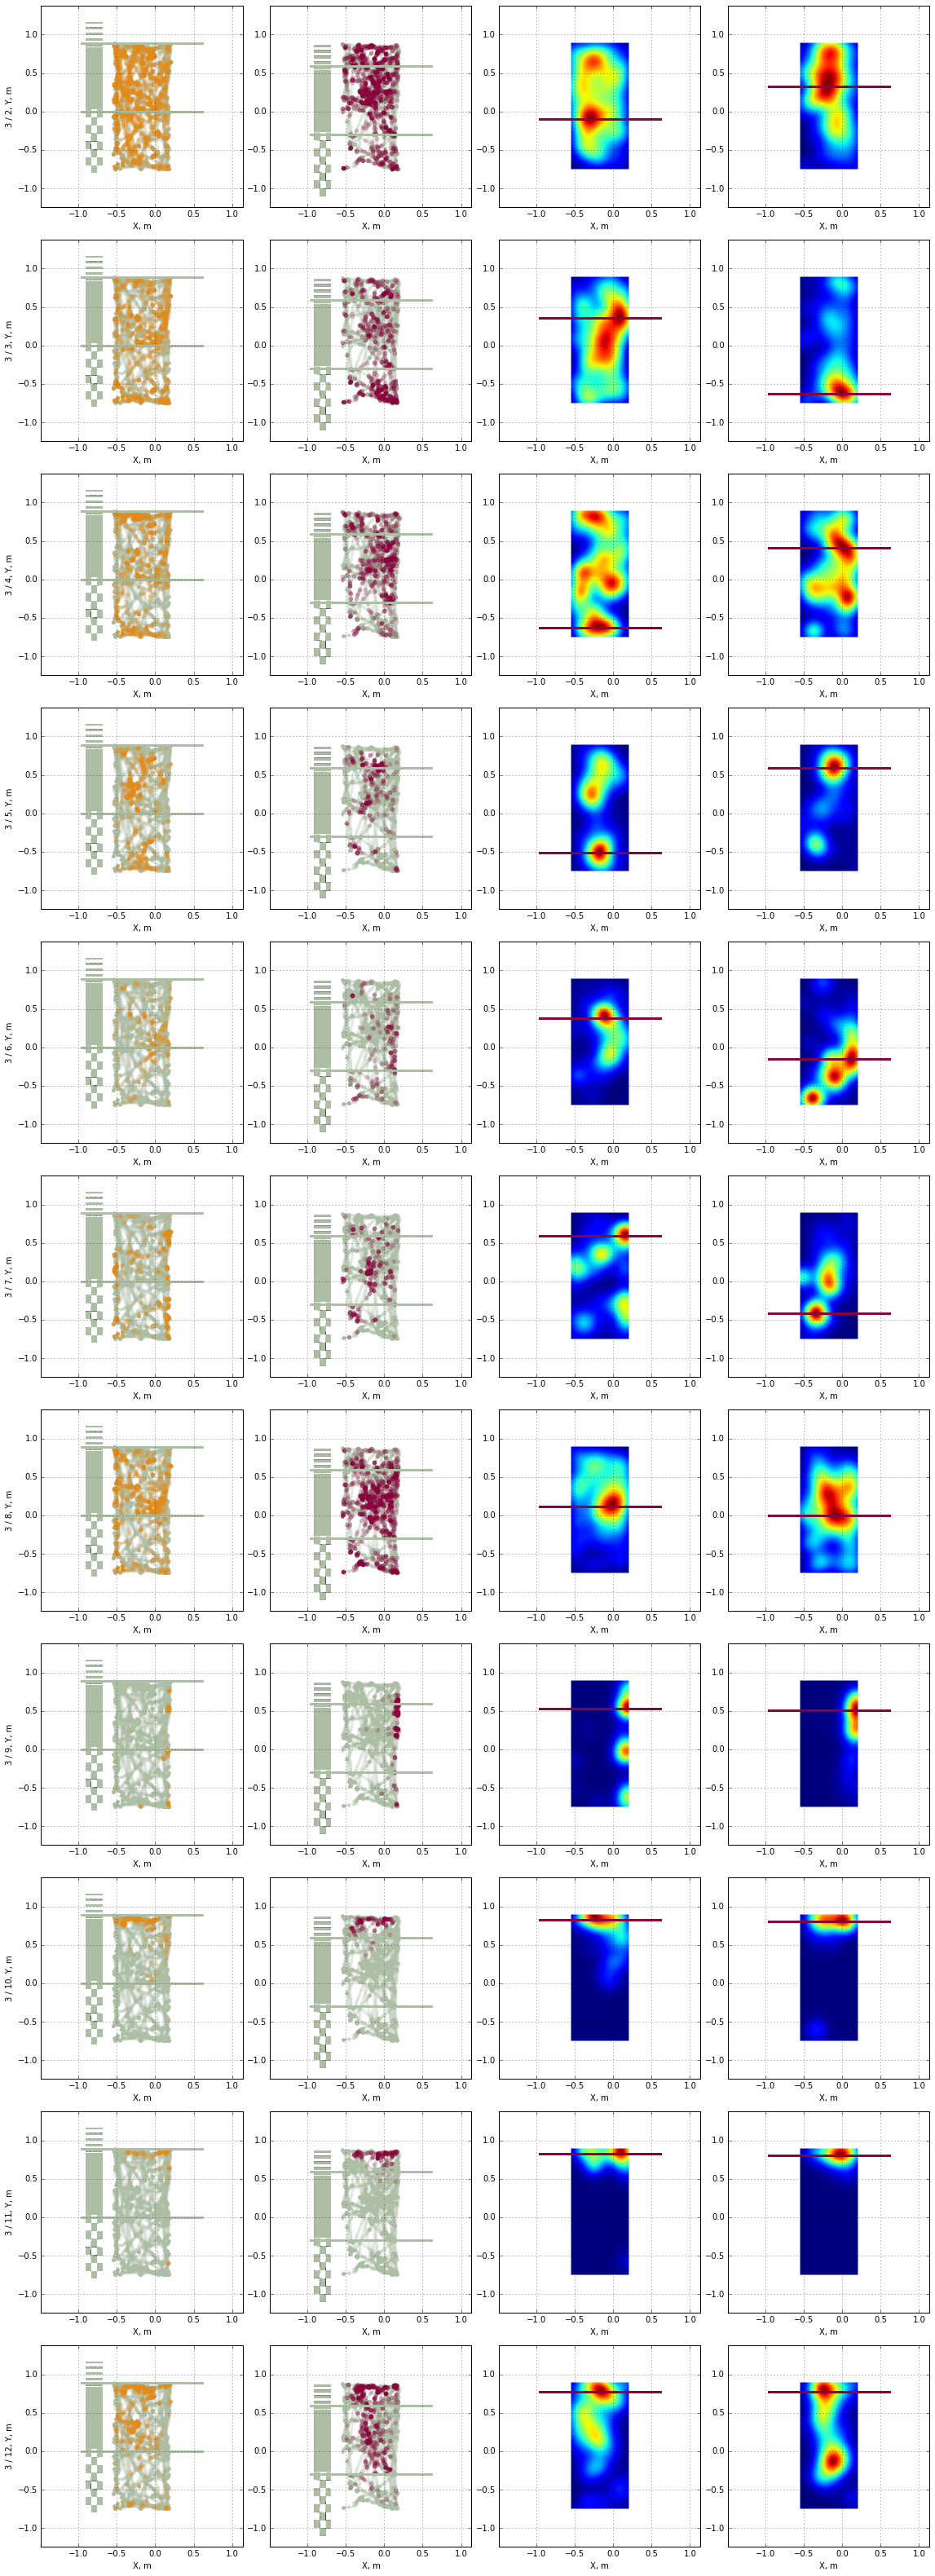

In [83]:
ttd_map = {
    2: [],
    3: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    #4: [2, 3, 4, 5, 7, 8, 9],
    #5: [2, 3, 4, 5, 6],
    #6: [2, 3, 4, 5, 6],
    #7: [2, 3, 4, 5],
}

fig = shift_place_plot(session, ttd_map, an_traj_0, an_traj_1, an_traj_0_idxs, an_traj_1_idxs)

filename = "shift_comparison.png"
fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))